# Graph-UNets

Hereafter is the implementation of the paper https://arxiv.org/pdf/1905.05178v1.pdf, this is indeed the method chosen from the ones listed in the survey paper https://arxiv.org/pdf/2110.05292.pdf

To summarize the approach we composed a UNet, with its characteristical skip connections, after which we simply inserted a linear layer. Such topping allowed us to adoperate a method widely adopted for generation tasks to exploit it for graph classification.

## Imports

In [2]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from torch import nn
from torch_geometric.nn import GCNConv,TopKPooling,global_mean_pool
from torch_geometric import seed_everything
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from torch_geometric.utils.sparse import dense_to_sparse,to_torch_coo_tensor
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## Dataset

For our experiment we picked the PROTEINS dataset, which is one of those selected in the Graph-UNets paper.  
The dataset was divided as such:
- 81% for the training set
- 9% for the validation set
- 10 % for the test set

In [3]:
seed_everything(77) #Seed for all random actions, this library is a proxy for other libraries, e.g. pytorch
path=""
dataset = TUDataset(path, name='PROTEINS').shuffle() #Here we shuffle the dataset to break any potential order correlation

print("Dataset is undirected? ", dataset[0].is_undirected()) #This is a vital information!
print ("Len of dataset: ", len(dataset))
train_set = dataset[:int(0.9*len(dataset))]
train_dataset = train_set[:int(0.9*len(train_set))]
val_dataset = train_set[int(0.9*len(train_set)):]
test_dataset = dataset[int(0.9*len(dataset)):]
print("Len of train dataset: ", len(train_dataset))
print("Len of validation dataset: ",len(val_dataset))
print("Len of test dataset: ",len(test_dataset))

batch_size=128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Dataset is undirected?  True
Len of dataset:  1113
Len of train dataset:  900
Len of validation dataset:  101
Len of test dataset:  112


## Graph Pooling

![title](experiments/graphpool.png)

In [4]:
class gPool(nn.Module):
    """
    Our implementation of the pooling methodology described in the paper, above you can see the pseudocode
    """
    def __init__(self,in_dim,ratio):
        super().__init__()
        self.in_dim=in_dim
        self.ratio=ratio
        self.p=nn.Linear(in_dim,1)
        self.sigmoid=nn.Sigmoid()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,edge_index):
        
        #y is described as a learnable projection, hence we estimated a linear layer to be a suitable choice
        
        y=self.p(xl) #/torch.norm(self.p(xl)) #DO WE HAVE TO INSERT THE NORM?
        
        k=int(self.ratio*len(y))#Number of selected nodes, the k in TopkPooling
        
        topks, idx =torch.topk(y,k,dim=0) #The k elements with top scores, and their corresponding idx
        
        y_hat=self.sigmoid(topks)
        xl_hat=xl[idx,:].squeeze() #Feature matrix of topk nodes
        xl1=xl_hat * y_hat  #Gate operation
        
        al = torch.as_tensor(to_scipy_sparse_matrix(edge_index,num_nodes=len(y)).todense(), device = self.device)
        al1 = torch.index_select(torch.as_tensor(al),0,idx.squeeze()) #no direct indexing because of ram overloading
        al1=torch.index_select(al1,1,idx.squeeze())
        sparsel1=dense_to_sparse(al1)
        edge_index_pooled=torch.sparse_coo_tensor(sparsel1[0],sparsel1[1]).coalesce().indices() #Our model elaborates coo tensors
        return xl1, edge_index_pooled, idx.squeeze()

In [5]:
"""
Simple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension
p=nn.Linear(4,1)
xl=torch.ones((6,4))
y=p(xl)/torch.norm(p(xl))
xl2=torch.ones((2,4))
print(torch.norm(p(xl),dim=0))
print(torch.norm(p(xl2),dim=0))
"""

'\nSimple example to prove that dim=0 in the norm is not equal for all inputs, depends on the dimension\np=nn.Linear(4,1)\nxl=torch.ones((6,4))\ny=p(xl)/torch.norm(p(xl))\nxl2=torch.ones((2,4))\nprint(torch.norm(p(xl),dim=0))\nprint(torch.norm(p(xl2),dim=0))\n'

## Graph Unpooling

In [6]:
class gUnpool(nn.Module):
    """
    Our implementation of the unpooling methodology described in the paper
    """
    def __init__(self,in_dim,out_dim):
        super().__init__()
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def forward(self,xl,idx,up_shape):
        up_nodes,C = up_shape #We extract the number of nodes and features the graph has to return to
        xl1=torch.zeros((up_nodes,xl.shape[1]), device = self.device)
        xl1[idx]=xl #We fetch the current feature matrix and sorround it of zeros to have the desired shape
        return xl1
        

## U-Net

The U-Net as described in the paper, below is the graphical representation in the paper, however the number of up and down blocks is inferior with respect to the paper description, which is four upblocks and four downblocks as presented in the code below.

![title](experiments/unet_structure.png)

In [7]:
class UNet(nn.Module):
    def __init__(self, improved = False, dropout = 0.3 ):
        super().__init__()
        """
        For the original operation we adoperated GCNConv, considered one of the "basic" convolutional layer for graphs
        """
        self.in_conv = GCNConv(dataset.num_features, 16, improved= improved)
        
        self.GC1 = GCNConv(16, 32, dropout= dropout, improved= improved) 
        self.GC2 = GCNConv(32, 64, dropout= dropout, improved= improved)
        self.GC3 = GCNConv(64, 128, dropout= dropout, improved= improved)
        self.GC4 = GCNConv(128, 256,dropout= dropout, improved= improved)
        self.act=nn.ELU()
        
        self.gPool1 = gPool(16, 0.9)
        self.gPool2 = gPool(32, 0.7)
        self.gPool3 = gPool(64, 0.6)
        self.gPool4 = gPool(128, 0.5)
        
        self.gUnpool1 = gUnpool(256, 128)
        self.gUnpool2 = gUnpool(128, 64)
        self.gUnpool3 = gUnpool(64, 32)
        self.gUnpool4 = gUnpool(32, 16)
        
        self.GC5 = GCNConv(256+128, 128, dropout= dropout, improved= improved) 
        self.GC6 = GCNConv(128+64, 64, dropout= dropout, improved= improved)
        self.GC7 = GCNConv(64+32, 32, dropout= dropout, improved= improved)
        self.GC8 = GCNConv(32+16, 16, dropout= dropout, improved= improved)
        
        self.out_conv = GCNConv(16, dataset.num_features, improved= improved)
        
        self.linear = nn.Linear(dataset.num_features, 1)
        
    
    def forward(self,x,edge_index,batch):
        x1 = self.in_conv(x, edge_index)
        x1 = self.act(x1)
        
        # Encoder
        
        #Pool1
        x2, edge_index2, idx2 = self.gPool1(x1,edge_index)
        x2 = self.act(x2)
        
        x3 = self.GC1(x2, edge_index2)
        x3 = self.act(x3)
        
        #Pool2
        x4,  edge_index4, idx4 = self.gPool2(x3,edge_index2)
        x4 = self.act(x4)
        
        x5 = self.GC2(x4, edge_index4)
        x5 = self.act(x5)
        
        #Pool3
        x6,  edge_index6, idx6 = self.gPool3(x5,edge_index4)
        x6 = self.act(x6)
        
        x7 = self.GC3(x6, edge_index6)
        x7 = self.act(x7)
        
        #Pool4
        x8,  edge_index8, idx8 = self.gPool4(x7,edge_index6)
        x8 = self.act(x8)
        
        x9 = self.GC4(x8, edge_index8)
        x9 = self.act(x9)
        
        #Decoder
        
        #Unpool1
        x10 = self.gUnpool1(x9,idx8,x7.shape)
        x10 = torch.cat([x7, x10], dim=1) #Skip connection, an alternative would be to use the sum, i.e. #x10 = x7 + x10
        x10 = self.act(x10)
        
        x11 = self.GC5(x10, edge_index8)
        x11 = self.act(x11)
        
        #Unpool2
        x12 = self.gUnpool2(x11,idx6,x5.shape)
        x12 = torch.cat([x5, x12], dim=1)
        x12 = self.act(x12)
        
        x13 = self.GC6(x12, edge_index6)
        x13 = self.act(x13)
        
        #Unpool3
        x14 = self.gUnpool3(x13,idx4,x3.shape)
        x14 = torch.cat([x3, x14], dim=1)
        x14 = self.act(x14)
        
        x15 = self.GC7(x14, edge_index4)
        x15 = self.act(x15)
        
        #Unpool4
        x16 = self.gUnpool4(x15,idx2,x1.shape)
        x16 = torch.cat([x1, x16], dim=1)
        x16 = self.act(x16)
        
        x17 = self.GC8(x16, edge_index2)
        x17 = self.act(x17)
        
        
        x18 = self.out_conv(x17, edge_index)
        x18 = self.act(x18)
        
        #Readout
        x19 = global_mean_pool(x18, batch) #readout layer commonly adoperated - reference: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=CN3sRVuaQ88l
        x19 = self.act(x19)
        
        #Linear
        x19=self.linear(x19)
        
        return x19

## Parameters customization

In [8]:
seed_everything(77)
lrate =0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=UNet(improved=False, dropout=0.3).to(device) #Customize the model by changing these parameters

optimizer = torch.optim.Adam(model.parameters(), lr=lrate) #Adam because it is adaptive
criterion=nn.BCEWithLogitsLoss()
sigmoid=nn.Sigmoid()
epochs=200

## Training

Here we start the training of the model, we perform one epoch on the training set and one on the validation set.

In [9]:
seed_everything(77)
train_losses=[]
val_losses=[]
train_accuracies=[]
val_accuracies=[]
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    train_acc=0.0
    for i, data in enumerate(tqdm(train_loader)):
        data = data.to(device) #E.g. DataBatch(edge_index=[2, 19062], x=[5024, 3], y=[128], batch=[5024], ptr=[129])
        optimizer.zero_grad()
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        loss.backward()
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        train_acc+=acc
        train_loss += loss.item()
        optimizer.step()
        
    epoch_train_loss=train_loss/len(train_loader) #We compute the average train loss for each epoch
    train_losses.append(epoch_train_loss)
    epoch_train_accuracy=train_acc/len(train_loader) #We compute the average train accuracy for each epoch
    train_accuracies.append(epoch_train_accuracy)
    print(f"Training loss epoch {epoch}: ", epoch_train_loss)
    print(f"Training accuracy epoch {epoch}: ", epoch_train_accuracy)
    
    model.eval()
    val_loss = 0.0
    val_acc=0.0
    for i, data in enumerate(tqdm(val_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        val_acc+=acc
        val_loss += loss.item()
    
    epoch_val_loss=val_loss/len(val_loader) #We compute the average validation loss for each epoch
    val_losses.append(epoch_val_loss)
    epoch_val_accuracy=val_acc/len(val_loader) #We compute the average validation accuracy for each epoch
    val_accuracies.append(epoch_val_accuracy)
    print(f"Validation loss epoch {epoch}: ", epoch_val_loss)
    print(f"Validation accuracy epoch {epoch}: ", epoch_val_accuracy)
print('Finished Training')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  2.75it/s]


Training loss epoch 0:  0.6770115196704865
Training accuracy epoch 0:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.32it/s]


Validation loss epoch 0:  0.6783123016357422
Validation accuracy epoch 0:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.88it/s]


Training loss epoch 1:  0.6895406618714333
Training accuracy epoch 1:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.65it/s]


Validation loss epoch 1:  0.6777211427688599
Validation accuracy epoch 1:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 2:  0.6652038171887398
Training accuracy epoch 2:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.67it/s]


Validation loss epoch 2:  0.6779659390449524
Validation accuracy epoch 2:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


Training loss epoch 3:  0.6528533697128296
Training accuracy epoch 3:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.72it/s]


Validation loss epoch 3:  0.6765402555465698
Validation accuracy epoch 3:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.59it/s]


Training loss epoch 4:  0.6741623133420944
Training accuracy epoch 4:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 4:  0.6783448457717896
Validation accuracy epoch 4:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 5:  0.6602444425225258
Training accuracy epoch 5:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.19it/s]


Validation loss epoch 5:  0.676548421382904
Validation accuracy epoch 5:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.65it/s]


Training loss epoch 6:  0.6768445372581482
Training accuracy epoch 6:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.64it/s]


Validation loss epoch 6:  0.6775855422019958
Validation accuracy epoch 6:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 7:  0.6737508103251457
Training accuracy epoch 7:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


Validation loss epoch 7:  0.6756097078323364
Validation accuracy epoch 7:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.95it/s]


Training loss epoch 8:  0.6645408943295479
Training accuracy epoch 8:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.24it/s]


Validation loss epoch 8:  0.6748567819595337
Validation accuracy epoch 8:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Training loss epoch 9:  0.6853231936693192
Training accuracy epoch 9:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.83it/s]


Validation loss epoch 9:  0.6760044097900391
Validation accuracy epoch 9:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 10:  0.6501378566026688
Training accuracy epoch 10:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.50it/s]


Validation loss epoch 10:  0.6750019788742065
Validation accuracy epoch 10:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.49it/s]


Training loss epoch 11:  0.6415954306721687
Training accuracy epoch 11:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.17it/s]


Validation loss epoch 11:  0.6773278713226318
Validation accuracy epoch 11:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 12:  0.6781121119856834
Training accuracy epoch 12:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Validation loss epoch 12:  0.6861620545387268
Validation accuracy epoch 12:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 13:  0.6755445376038551
Training accuracy epoch 13:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 13:  0.6781215667724609
Validation accuracy epoch 13:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 14:  0.6490588560700417
Training accuracy epoch 14:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Validation loss epoch 14:  0.6751644611358643
Validation accuracy epoch 14:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Training loss epoch 15:  0.6756490916013718
Training accuracy epoch 15:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 15:  0.6743820309638977
Validation accuracy epoch 15:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 16:  0.6706763505935669
Training accuracy epoch 16:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Validation loss epoch 16:  0.6731771230697632
Validation accuracy epoch 16:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.46it/s]


Training loss epoch 17:  0.6759657487273216
Training accuracy epoch 17:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 17:  0.6739194989204407
Validation accuracy epoch 17:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 18:  0.6648986116051674
Training accuracy epoch 18:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.00it/s]


Validation loss epoch 18:  0.673743486404419
Validation accuracy epoch 18:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.85it/s]


Training loss epoch 19:  0.6723125502467155
Training accuracy epoch 19:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 19:  0.6722149848937988
Validation accuracy epoch 19:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.11it/s]


Training loss epoch 20:  0.6686645746231079
Training accuracy epoch 20:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Validation loss epoch 20:  0.6741733551025391
Validation accuracy epoch 20:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.40it/s]


Training loss epoch 21:  0.6864818558096886
Training accuracy epoch 21:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 21:  0.6701510548591614
Validation accuracy epoch 21:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 22:  0.6504709124565125
Training accuracy epoch 22:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Validation loss epoch 22:  0.6710734963417053
Validation accuracy epoch 22:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Training loss epoch 23:  0.6562300398945808
Training accuracy epoch 23:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 23:  0.6731283068656921
Validation accuracy epoch 23:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.88it/s]


Training loss epoch 24:  0.6742707341909409
Training accuracy epoch 24:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 24:  0.6761952638626099
Validation accuracy epoch 24:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 25:  0.6783936470746994
Training accuracy epoch 25:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]


Validation loss epoch 25:  0.6728599071502686
Validation accuracy epoch 25:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.09it/s]


Training loss epoch 26:  0.6829775646328926
Training accuracy epoch 26:  0.5615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.09it/s]


Validation loss epoch 26:  0.6722883582115173
Validation accuracy epoch 26:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 27:  0.6763134449720383
Training accuracy epoch 27:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.61it/s]


Validation loss epoch 27:  0.6742712259292603
Validation accuracy epoch 27:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.40it/s]


Training loss epoch 28:  0.6656951606273651
Training accuracy epoch 28:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.34it/s]


Validation loss epoch 28:  0.6712676882743835
Validation accuracy epoch 28:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.75it/s]


Training loss epoch 29:  0.6684447228908539
Training accuracy epoch 29:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Validation loss epoch 29:  0.6701586842536926
Validation accuracy epoch 29:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 30:  0.6732476279139519
Training accuracy epoch 30:  0.591796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.39it/s]


Validation loss epoch 30:  0.6698473691940308
Validation accuracy epoch 30:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.53it/s]


Training loss epoch 31:  0.6512537598609924
Training accuracy epoch 31:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 31:  0.6685686111450195
Validation accuracy epoch 31:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 32:  0.6598889902234077
Training accuracy epoch 32:  0.625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 32:  0.6669077277183533
Validation accuracy epoch 32:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.71it/s]


Training loss epoch 33:  0.6571252718567848
Training accuracy epoch 33:  0.6240234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.04it/s]


Validation loss epoch 33:  0.6669628024101257
Validation accuracy epoch 33:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 34:  0.6510725766420364
Training accuracy epoch 34:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 34:  0.6617664098739624
Validation accuracy epoch 34:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 35:  0.6684489622712135
Training accuracy epoch 35:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 35:  0.6557584404945374
Validation accuracy epoch 35:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.57it/s]


Training loss epoch 36:  0.6598289534449577
Training accuracy epoch 36:  0.623046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.12it/s]


Validation loss epoch 36:  0.6580176949501038
Validation accuracy epoch 36:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 37:  0.6605144143104553
Training accuracy epoch 37:  0.626953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Validation loss epoch 37:  0.6605402827262878
Validation accuracy epoch 37:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.41it/s]


Training loss epoch 38:  0.6502990126609802
Training accuracy epoch 38:  0.626953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.96it/s]


Validation loss epoch 38:  0.6495990753173828
Validation accuracy epoch 38:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Training loss epoch 39:  0.6355559527873993
Training accuracy epoch 39:  0.6513671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.94it/s]


Validation loss epoch 39:  0.6519738435745239
Validation accuracy epoch 39:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 40:  0.6740156561136246
Training accuracy epoch 40:  0.59765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 40:  0.6565737724304199
Validation accuracy epoch 40:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.42it/s]


Training loss epoch 41:  0.6625543981790543
Training accuracy epoch 41:  0.5986328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 41:  0.6645220518112183
Validation accuracy epoch 41:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.67it/s]


Training loss epoch 42:  0.6717078387737274
Training accuracy epoch 42:  0.595703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.51it/s]


Validation loss epoch 42:  0.6479501128196716
Validation accuracy epoch 42:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.93it/s]


Training loss epoch 43:  0.6525718569755554
Training accuracy epoch 43:  0.62890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.89it/s]


Validation loss epoch 43:  0.6445676684379578
Validation accuracy epoch 43:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.40it/s]


Training loss epoch 44:  0.6341088078916073
Training accuracy epoch 44:  0.6552734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 44:  0.647446870803833
Validation accuracy epoch 44:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 45:  0.6748002469539642
Training accuracy epoch 45:  0.6015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


Validation loss epoch 45:  0.6532537341117859
Validation accuracy epoch 45:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.40it/s]


Training loss epoch 46:  0.6569938212633133
Training accuracy epoch 46:  0.634765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 46:  0.650860071182251
Validation accuracy epoch 46:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.77it/s]


Training loss epoch 47:  0.6433513760566711
Training accuracy epoch 47:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


Validation loss epoch 47:  0.649842381477356
Validation accuracy epoch 47:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 48:  0.6525209546089172
Training accuracy epoch 48:  0.6259765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 48:  0.6475050449371338
Validation accuracy epoch 48:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.36it/s]


Training loss epoch 49:  0.651169165968895
Training accuracy epoch 49:  0.62890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 49:  0.6434521079063416
Validation accuracy epoch 49:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 50:  0.6775296628475189
Training accuracy epoch 50:  0.5673828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Validation loss epoch 50:  0.6505147814750671
Validation accuracy epoch 50:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.82it/s]


Training loss epoch 51:  0.6496694311499596
Training accuracy epoch 51:  0.6474609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Validation loss epoch 51:  0.644644558429718
Validation accuracy epoch 51:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Training loss epoch 52:  0.6605616211891174
Training accuracy epoch 52:  0.6181640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Validation loss epoch 52:  0.6405069828033447
Validation accuracy epoch 52:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.94it/s]


Training loss epoch 53:  0.6437786892056465
Training accuracy epoch 53:  0.63671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Validation loss epoch 53:  0.643086850643158
Validation accuracy epoch 53:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.28it/s]


Training loss epoch 54:  0.6336885988712311
Training accuracy epoch 54:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.80it/s]


Validation loss epoch 54:  0.665654182434082
Validation accuracy epoch 54:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 55:  0.6966531798243523
Training accuracy epoch 55:  0.59375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.41it/s]


Validation loss epoch 55:  0.658528208732605
Validation accuracy epoch 55:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.48it/s]


Training loss epoch 56:  0.6775263994932175
Training accuracy epoch 56:  0.5732421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.75it/s]


Validation loss epoch 56:  0.6572201251983643
Validation accuracy epoch 56:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.81it/s]


Training loss epoch 57:  0.6585223823785782
Training accuracy epoch 57:  0.646484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 57:  0.6582265496253967
Validation accuracy epoch 57:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Training loss epoch 58:  0.6794926971197128
Training accuracy epoch 58:  0.5771484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Validation loss epoch 58:  0.6480194330215454
Validation accuracy epoch 58:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


Training loss epoch 59:  0.6489275321364403
Training accuracy epoch 59:  0.6728515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Validation loss epoch 59:  0.6481451392173767
Validation accuracy epoch 59:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 60:  0.6561250984668732
Training accuracy epoch 60:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.03it/s]


Validation loss epoch 60:  0.6432764530181885
Validation accuracy epoch 60:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.69it/s]


Training loss epoch 61:  0.6498754173517227
Training accuracy epoch 61:  0.6455078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.36it/s]


Validation loss epoch 61:  0.6478212475776672
Validation accuracy epoch 61:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 62:  0.6361638903617859
Training accuracy epoch 62:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 62:  0.6359614729881287
Validation accuracy epoch 62:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 63:  0.6836531683802605
Training accuracy epoch 63:  0.5751953125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 63:  0.6280364394187927
Validation accuracy epoch 63:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.11it/s]


Training loss epoch 64:  0.6530422791838646
Training accuracy epoch 64:  0.6298828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


Validation loss epoch 64:  0.6486344337463379
Validation accuracy epoch 64:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.47it/s]


Training loss epoch 65:  0.6644806563854218
Training accuracy epoch 65:  0.6083984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 65:  0.6311071515083313
Validation accuracy epoch 65:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 66:  0.6258414201438427
Training accuracy epoch 66:  0.6865234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.55it/s]


Validation loss epoch 66:  0.6312512755393982
Validation accuracy epoch 66:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 67:  0.6756838336586952
Training accuracy epoch 67:  0.5908203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 67:  0.634520411491394
Validation accuracy epoch 67:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.73it/s]


Training loss epoch 68:  0.6641353890299797
Training accuracy epoch 68:  0.61328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Validation loss epoch 68:  0.6292915344238281
Validation accuracy epoch 68:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]


Training loss epoch 69:  0.6722929179668427
Training accuracy epoch 69:  0.59375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


Validation loss epoch 69:  0.6423218846321106
Validation accuracy epoch 69:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 70:  0.6609994247555733
Training accuracy epoch 70:  0.6455078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.69it/s]


Validation loss epoch 70:  0.6410624980926514
Validation accuracy epoch 70:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 71:  0.6356575191020966
Training accuracy epoch 71:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Validation loss epoch 71:  0.6328495740890503
Validation accuracy epoch 71:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


Training loss epoch 72:  0.649387314915657
Training accuracy epoch 72:  0.6455078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.78it/s]


Validation loss epoch 72:  0.6327053308486938
Validation accuracy epoch 72:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.86it/s]


Training loss epoch 73:  0.6466283723711967
Training accuracy epoch 73:  0.6416015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Validation loss epoch 73:  0.6370158791542053
Validation accuracy epoch 73:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]


Training loss epoch 74:  0.6433378756046295
Training accuracy epoch 74:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.53it/s]


Validation loss epoch 74:  0.6348366737365723
Validation accuracy epoch 74:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 75:  0.6287130042910576
Training accuracy epoch 75:  0.65625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.66it/s]


Validation loss epoch 75:  0.6303400993347168
Validation accuracy epoch 75:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 76:  0.6365940533578396
Training accuracy epoch 76:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.35it/s]


Validation loss epoch 76:  0.6435860991477966
Validation accuracy epoch 76:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


Training loss epoch 77:  0.6459759175777435
Training accuracy epoch 77:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 77:  0.6299906373023987
Validation accuracy epoch 77:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 78:  0.6566415503621101
Training accuracy epoch 78:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.75it/s]


Validation loss epoch 78:  0.6333823800086975
Validation accuracy epoch 78:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Training loss epoch 79:  0.7342012673616409
Training accuracy epoch 79:  0.5703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.25it/s]


Validation loss epoch 79:  0.6314437389373779
Validation accuracy epoch 79:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 80:  0.6556636169552803
Training accuracy epoch 80:  0.6240234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.44it/s]


Validation loss epoch 80:  0.6491518616676331
Validation accuracy epoch 80:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 81:  0.6563030704855919
Training accuracy epoch 81:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 81:  0.6479288935661316
Validation accuracy epoch 81:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.78it/s]


Training loss epoch 82:  0.6427488401532173
Training accuracy epoch 82:  0.6318359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.47it/s]


Validation loss epoch 82:  0.6469565033912659
Validation accuracy epoch 82:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.54it/s]


Training loss epoch 83:  0.6497491672635078
Training accuracy epoch 83:  0.638671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 83:  0.642712414264679
Validation accuracy epoch 83:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.38it/s]


Training loss epoch 84:  0.6280721686780453
Training accuracy epoch 84:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Validation loss epoch 84:  0.6530877947807312
Validation accuracy epoch 84:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.32it/s]


Training loss epoch 85:  0.6294981315732002
Training accuracy epoch 85:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 85:  0.6483158469200134
Validation accuracy epoch 85:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.83it/s]


Training loss epoch 86:  0.6547702103853226
Training accuracy epoch 86:  0.60546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 86:  0.6428118944168091
Validation accuracy epoch 86:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.21it/s]


Training loss epoch 87:  0.6272124461829662
Training accuracy epoch 87:  0.67578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 87:  0.6469119191169739
Validation accuracy epoch 87:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.47it/s]


Training loss epoch 88:  0.6457911655306816
Training accuracy epoch 88:  0.6455078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.04it/s]


Validation loss epoch 88:  0.6392393708229065
Validation accuracy epoch 88:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.00it/s]


Training loss epoch 89:  0.6687253192067146
Training accuracy epoch 89:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.90it/s]


Validation loss epoch 89:  0.6248771548271179
Validation accuracy epoch 89:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 90:  0.6151636950671673
Training accuracy epoch 90:  0.6767578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 90:  0.6422215700149536
Validation accuracy epoch 90:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.18it/s]


Training loss epoch 91:  0.653140090405941
Training accuracy epoch 91:  0.625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Validation loss epoch 91:  0.6633417010307312
Validation accuracy epoch 91:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Training loss epoch 92:  0.6417599990963936
Training accuracy epoch 92:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 92:  0.652291476726532
Validation accuracy epoch 92:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 93:  0.6679484248161316
Training accuracy epoch 93:  0.5966796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.81it/s]


Validation loss epoch 93:  0.6505663394927979
Validation accuracy epoch 93:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.59it/s]


Training loss epoch 94:  0.649447612464428
Training accuracy epoch 94:  0.646484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.80it/s]


Validation loss epoch 94:  0.641382098197937
Validation accuracy epoch 94:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.33it/s]


Training loss epoch 95:  0.6790302321314812
Training accuracy epoch 95:  0.5791015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


Validation loss epoch 95:  0.648774266242981
Validation accuracy epoch 95:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.61it/s]


Training loss epoch 96:  0.67100889980793
Training accuracy epoch 96:  0.6171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.33it/s]


Validation loss epoch 96:  0.6480022072792053
Validation accuracy epoch 96:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 97:  0.6678324714303017
Training accuracy epoch 97:  0.6708984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 97:  0.6228417158126831
Validation accuracy epoch 97:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 98:  0.6613506823778152
Training accuracy epoch 98:  0.6123046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Validation loss epoch 98:  0.6323123574256897
Validation accuracy epoch 98:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


Training loss epoch 99:  0.6501670479774475
Training accuracy epoch 99:  0.66796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


Validation loss epoch 99:  0.640223503112793
Validation accuracy epoch 99:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 100:  0.6541560217738152
Training accuracy epoch 100:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.85it/s]


Validation loss epoch 100:  0.6197707653045654
Validation accuracy epoch 100:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.94it/s]


Training loss epoch 101:  0.6619124412536621
Training accuracy epoch 101:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 101:  0.6350092887878418
Validation accuracy epoch 101:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 102:  0.6461930572986603
Training accuracy epoch 102:  0.654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


Validation loss epoch 102:  0.6243755221366882
Validation accuracy epoch 102:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Training loss epoch 103:  0.6509338244795799
Training accuracy epoch 103:  0.619140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.88it/s]


Validation loss epoch 103:  0.6297608613967896
Validation accuracy epoch 103:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Training loss epoch 104:  0.6723135858774185
Training accuracy epoch 104:  0.609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]


Validation loss epoch 104:  0.6309205293655396
Validation accuracy epoch 104:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 105:  0.6342623829841614
Training accuracy epoch 105:  0.6513671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.19it/s]


Validation loss epoch 105:  0.6295127272605896
Validation accuracy epoch 105:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.26it/s]


Training loss epoch 106:  0.6533344015479088
Training accuracy epoch 106:  0.64453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.86it/s]


Validation loss epoch 106:  0.6300935745239258
Validation accuracy epoch 106:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Training loss epoch 107:  0.6352893337607384
Training accuracy epoch 107:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 107:  0.6392512917518616
Validation accuracy epoch 107:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 108:  0.6261255480349064
Training accuracy epoch 108:  0.6904296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 108:  0.6344192028045654
Validation accuracy epoch 108:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 109:  0.6366393715143204
Training accuracy epoch 109:  0.6650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.46it/s]


Validation loss epoch 109:  0.6296432018280029
Validation accuracy epoch 109:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.29it/s]


Training loss epoch 110:  0.625146321952343
Training accuracy epoch 110:  0.671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.65it/s]


Validation loss epoch 110:  0.6233856081962585
Validation accuracy epoch 110:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]


Training loss epoch 111:  0.6647965088486671
Training accuracy epoch 111:  0.6259765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.52it/s]


Validation loss epoch 111:  0.6125631332397461
Validation accuracy epoch 111:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.52it/s]


Training loss epoch 112:  0.634184218943119
Training accuracy epoch 112:  0.662109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.77it/s]


Validation loss epoch 112:  0.6330350041389465
Validation accuracy epoch 112:  0.5841584158415841


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.64it/s]


Training loss epoch 113:  0.6856239885091782
Training accuracy epoch 113:  0.5859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.73it/s]


Validation loss epoch 113:  0.6406798362731934
Validation accuracy epoch 113:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 114:  0.67446518689394
Training accuracy epoch 114:  0.5830078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 114:  0.6526510119438171
Validation accuracy epoch 114:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 115:  0.6755824536085129
Training accuracy epoch 115:  0.6005859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.43it/s]


Validation loss epoch 115:  0.6505184769630432
Validation accuracy epoch 115:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.43it/s]


Training loss epoch 116:  0.6534940972924232
Training accuracy epoch 116:  0.6484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.47it/s]


Validation loss epoch 116:  0.6459612846374512
Validation accuracy epoch 116:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 117:  0.6539718434214592
Training accuracy epoch 117:  0.6337890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.98it/s]


Validation loss epoch 117:  0.6466512084007263
Validation accuracy epoch 117:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.27it/s]


Training loss epoch 118:  0.6500167697668076
Training accuracy epoch 118:  0.6123046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.08it/s]


Validation loss epoch 118:  0.6371366381645203
Validation accuracy epoch 118:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.52it/s]


Training loss epoch 119:  0.6600595042109489
Training accuracy epoch 119:  0.6181640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.29it/s]


Validation loss epoch 119:  0.6360341906547546
Validation accuracy epoch 119:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 120:  0.6229956448078156
Training accuracy epoch 120:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.16it/s]


Validation loss epoch 120:  0.6361075639724731
Validation accuracy epoch 120:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.23it/s]


Training loss epoch 121:  0.6801706850528717
Training accuracy epoch 121:  0.609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 121:  0.643803060054779
Validation accuracy epoch 121:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


Training loss epoch 122:  0.6731077134609222
Training accuracy epoch 122:  0.6201171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Validation loss epoch 122:  0.64775550365448
Validation accuracy epoch 122:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 123:  0.6634733602404594
Training accuracy epoch 123:  0.6259765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.55it/s]


Validation loss epoch 123:  0.6476059556007385
Validation accuracy epoch 123:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


Training loss epoch 124:  0.6623098105192184
Training accuracy epoch 124:  0.6201171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.63it/s]


Validation loss epoch 124:  0.6410195827484131
Validation accuracy epoch 124:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.90it/s]


Training loss epoch 125:  0.6430545672774315
Training accuracy epoch 125:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 125:  0.6462609767913818
Validation accuracy epoch 125:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.87it/s]


Training loss epoch 126:  0.6748973652720451
Training accuracy epoch 126:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 126:  0.6424509286880493
Validation accuracy epoch 126:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]


Training loss epoch 127:  0.6585879698395729
Training accuracy epoch 127:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.40it/s]


Validation loss epoch 127:  0.6399868130683899
Validation accuracy epoch 127:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]


Training loss epoch 128:  0.6388762071728706
Training accuracy epoch 128:  0.66015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.96it/s]


Validation loss epoch 128:  0.635998010635376
Validation accuracy epoch 128:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 129:  0.6705890446901321
Training accuracy epoch 129:  0.595703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.69it/s]


Validation loss epoch 129:  0.6341090798377991
Validation accuracy epoch 129:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.80it/s]


Training loss epoch 130:  0.647323340177536
Training accuracy epoch 130:  0.6162109375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 130:  0.6393998265266418
Validation accuracy epoch 130:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 131:  0.6749230399727821
Training accuracy epoch 131:  0.6279296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 131:  0.6348041892051697
Validation accuracy epoch 131:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 132:  0.6444358602166176
Training accuracy epoch 132:  0.6298828125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.43it/s]


Validation loss epoch 132:  0.6340920329093933
Validation accuracy epoch 132:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.19it/s]


Training loss epoch 133:  0.6667351052165031
Training accuracy epoch 133:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.27it/s]


Validation loss epoch 133:  0.6418845057487488
Validation accuracy epoch 133:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.68it/s]


Training loss epoch 134:  0.6440147757530212
Training accuracy epoch 134:  0.65625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.26it/s]


Validation loss epoch 134:  0.6457852721214294
Validation accuracy epoch 134:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.08it/s]


Training loss epoch 135:  0.6266366206109524
Training accuracy epoch 135:  0.64453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.07it/s]


Validation loss epoch 135:  0.6447932720184326
Validation accuracy epoch 135:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.14it/s]


Training loss epoch 136:  0.6297575794160366
Training accuracy epoch 136:  0.6357421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.04it/s]


Validation loss epoch 136:  0.6517595052719116
Validation accuracy epoch 136:  0.594059405940594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 137:  0.6275987699627876
Training accuracy epoch 137:  0.6748046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.17it/s]


Validation loss epoch 137:  0.6485270857810974
Validation accuracy epoch 137:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.02it/s]


Training loss epoch 138:  0.6390152052044868
Training accuracy epoch 138:  0.6337890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.13it/s]


Validation loss epoch 138:  0.6241713166236877
Validation accuracy epoch 138:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 139:  0.6204526498913765
Training accuracy epoch 139:  0.697265625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Validation loss epoch 139:  0.6359264850616455
Validation accuracy epoch 139:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 140:  0.6365930736064911
Training accuracy epoch 140:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.29it/s]


Validation loss epoch 140:  0.6283056139945984
Validation accuracy epoch 140:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.45it/s]


Training loss epoch 141:  0.6662783324718475
Training accuracy epoch 141:  0.615234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 141:  0.6184781193733215
Validation accuracy epoch 141:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.54it/s]


Training loss epoch 142:  0.6685616448521614
Training accuracy epoch 142:  0.595703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.87it/s]


Validation loss epoch 142:  0.6310712695121765
Validation accuracy epoch 142:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 143:  0.664065919816494
Training accuracy epoch 143:  0.623046875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.33it/s]


Validation loss epoch 143:  0.6418065428733826
Validation accuracy epoch 143:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 144:  0.683034747838974
Training accuracy epoch 144:  0.5927734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 144:  0.624306857585907
Validation accuracy epoch 144:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.28it/s]


Training loss epoch 145:  0.6437754333019257
Training accuracy epoch 145:  0.703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.90it/s]


Validation loss epoch 145:  0.6255345940589905
Validation accuracy epoch 145:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.84it/s]


Training loss epoch 146:  0.6439038291573524
Training accuracy epoch 146:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.84it/s]


Validation loss epoch 146:  0.6480208039283752
Validation accuracy epoch 146:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.84it/s]


Training loss epoch 147:  0.6456502377986908
Training accuracy epoch 147:  0.6142578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.99it/s]


Validation loss epoch 147:  0.644554078578949
Validation accuracy epoch 147:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.06it/s]


Training loss epoch 148:  0.6265560574829578
Training accuracy epoch 148:  0.69140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


Validation loss epoch 148:  0.6402937769889832
Validation accuracy epoch 148:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.34it/s]


Training loss epoch 149:  0.6335495263338089
Training accuracy epoch 149:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.70it/s]


Validation loss epoch 149:  0.6281459927558899
Validation accuracy epoch 149:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.33it/s]


Training loss epoch 150:  0.6430639401078224
Training accuracy epoch 150:  0.6669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.27it/s]


Validation loss epoch 150:  0.6263664960861206
Validation accuracy epoch 150:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.16it/s]


Training loss epoch 151:  0.6020651236176491
Training accuracy epoch 151:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.21it/s]


Validation loss epoch 151:  0.6109184622764587
Validation accuracy epoch 151:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


Training loss epoch 152:  0.6798685789108276
Training accuracy epoch 152:  0.5888671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.68it/s]


Validation loss epoch 152:  0.632820188999176
Validation accuracy epoch 152:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.79it/s]


Training loss epoch 153:  0.662623904645443
Training accuracy epoch 153:  0.6259765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.80it/s]


Validation loss epoch 153:  0.623336136341095
Validation accuracy epoch 153:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.99it/s]


Training loss epoch 154:  0.6443945989012718
Training accuracy epoch 154:  0.6435546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 154:  0.6341317892074585
Validation accuracy epoch 154:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.38it/s]


Training loss epoch 155:  0.6250953637063503
Training accuracy epoch 155:  0.685546875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.13it/s]


Validation loss epoch 155:  0.6237265467643738
Validation accuracy epoch 155:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.23it/s]


Training loss epoch 156:  0.6638156548142433
Training accuracy epoch 156:  0.66796875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.44it/s]


Validation loss epoch 156:  0.6115214228630066
Validation accuracy epoch 156:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.96it/s]


Training loss epoch 157:  0.6371704861521721
Training accuracy epoch 157:  0.6328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.30it/s]


Validation loss epoch 157:  0.6209341883659363
Validation accuracy epoch 157:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.26it/s]


Training loss epoch 158:  0.6654030978679657
Training accuracy epoch 158:  0.6103515625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.92it/s]


Validation loss epoch 158:  0.6202365159988403
Validation accuracy epoch 158:  0.7029702970297029


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.97it/s]


Training loss epoch 159:  0.6578445062041283
Training accuracy epoch 159:  0.666015625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.54it/s]


Validation loss epoch 159:  0.6395396590232849
Validation accuracy epoch 159:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 160:  0.6484673470258713
Training accuracy epoch 160:  0.6357421875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.94it/s]


Validation loss epoch 160:  0.6343157291412354
Validation accuracy epoch 160:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


Training loss epoch 161:  0.6560884937644005
Training accuracy epoch 161:  0.634765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.15it/s]


Validation loss epoch 161:  0.6331186890602112
Validation accuracy epoch 161:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77it/s]


Training loss epoch 162:  0.6479333266615868
Training accuracy epoch 162:  0.6083984375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.12it/s]


Validation loss epoch 162:  0.6205048561096191
Validation accuracy epoch 162:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.12it/s]


Training loss epoch 163:  0.6452569365501404
Training accuracy epoch 163:  0.6650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.23it/s]


Validation loss epoch 163:  0.6203044652938843
Validation accuracy epoch 163:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 164:  0.6416288167238235
Training accuracy epoch 164:  0.6533203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.99it/s]


Validation loss epoch 164:  0.6147245764732361
Validation accuracy epoch 164:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.42it/s]


Training loss epoch 165:  0.647403359413147
Training accuracy epoch 165:  0.62890625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.60it/s]


Validation loss epoch 165:  0.6346538662910461
Validation accuracy epoch 165:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 166:  0.6929666101932526
Training accuracy epoch 166:  0.599609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.84it/s]


Validation loss epoch 166:  0.6234729886054993
Validation accuracy epoch 166:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.74it/s]


Training loss epoch 167:  0.6628213673830032
Training accuracy epoch 167:  0.625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.73it/s]


Validation loss epoch 167:  0.6319332718849182
Validation accuracy epoch 167:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.26it/s]


Training loss epoch 168:  0.6312277466058731
Training accuracy epoch 168:  0.669921875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.41it/s]


Validation loss epoch 168:  0.6286863684654236
Validation accuracy epoch 168:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.35it/s]


Training loss epoch 169:  0.6205468997359276
Training accuracy epoch 169:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.19it/s]


Validation loss epoch 169:  0.640948474407196
Validation accuracy epoch 169:  0.6039603960396039


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.11it/s]


Training loss epoch 170:  0.6286057159304619
Training accuracy epoch 170:  0.650390625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 170:  0.6341410875320435
Validation accuracy epoch 170:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.29it/s]


Training loss epoch 171:  0.6350956708192825
Training accuracy epoch 171:  0.6552734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.91it/s]


Validation loss epoch 171:  0.6238846778869629
Validation accuracy epoch 171:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 172:  0.6305485591292381
Training accuracy epoch 172:  0.677734375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.65it/s]


Validation loss epoch 172:  0.6167224645614624
Validation accuracy epoch 172:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.89it/s]


Training loss epoch 173:  0.6480879262089729
Training accuracy epoch 173:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.52it/s]


Validation loss epoch 173:  0.6314811706542969
Validation accuracy epoch 173:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.15it/s]


Training loss epoch 174:  0.6038201227784157
Training accuracy epoch 174:  0.71484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 174:  0.6117929816246033
Validation accuracy epoch 174:  0.693069306930693


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.24it/s]


Training loss epoch 175:  0.6376627162098885
Training accuracy epoch 175:  0.6611328125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Validation loss epoch 175:  0.6347571611404419
Validation accuracy epoch 175:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.00it/s]


Training loss epoch 176:  0.6819986030459404
Training accuracy epoch 176:  0.630859375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.40it/s]


Validation loss epoch 176:  0.6157199740409851
Validation accuracy epoch 176:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.17it/s]


Training loss epoch 177:  0.6333510503172874
Training accuracy epoch 177:  0.658203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.84it/s]


Validation loss epoch 177:  0.617591381072998
Validation accuracy epoch 177:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.85it/s]


Training loss epoch 178:  0.6387857273221016
Training accuracy epoch 178:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.04it/s]


Validation loss epoch 178:  0.6336603164672852
Validation accuracy epoch 178:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.63it/s]


Training loss epoch 179:  0.6333038285374641
Training accuracy epoch 179:  0.68359375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.76it/s]


Validation loss epoch 179:  0.6223429441452026
Validation accuracy epoch 179:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.37it/s]


Training loss epoch 180:  0.6642436385154724
Training accuracy epoch 180:  0.63671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.22it/s]


Validation loss epoch 180:  0.6207926273345947
Validation accuracy epoch 180:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.07it/s]


Training loss epoch 181:  0.6517451032996178
Training accuracy epoch 181:  0.642578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.74it/s]


Validation loss epoch 181:  0.6084855198860168
Validation accuracy epoch 181:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.77it/s]


Training loss epoch 182:  0.6688588783144951
Training accuracy epoch 182:  0.6220703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.04it/s]


Validation loss epoch 182:  0.6158289313316345
Validation accuracy epoch 182:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.13it/s]


Training loss epoch 183:  0.6254762336611748
Training accuracy epoch 183:  0.6875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.58it/s]


Validation loss epoch 183:  0.6204142570495605
Validation accuracy epoch 183:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.63it/s]


Training loss epoch 184:  0.6971776932477951
Training accuracy epoch 184:  0.609375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.56it/s]


Validation loss epoch 184:  0.6196052432060242
Validation accuracy epoch 184:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.53it/s]


Training loss epoch 185:  0.6227584034204483
Training accuracy epoch 185:  0.6884765625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.20it/s]


Validation loss epoch 185:  0.6387761831283569
Validation accuracy epoch 185:  0.6138613861386139


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.51it/s]


Training loss epoch 186:  0.6005526483058929
Training accuracy epoch 186:  0.689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.02it/s]


Validation loss epoch 186:  0.6234760284423828
Validation accuracy epoch 186:  0.6534653465346535


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.02it/s]


Training loss epoch 187:  0.6542879343032837
Training accuracy epoch 187:  0.646484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Validation loss epoch 187:  0.6227279305458069
Validation accuracy epoch 187:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.01it/s]


Training loss epoch 188:  0.615358792245388
Training accuracy epoch 188:  0.6845703125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.29it/s]


Validation loss epoch 188:  0.6339673399925232
Validation accuracy epoch 188:  0.6237623762376238


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.25it/s]


Training loss epoch 189:  0.6271225959062576
Training accuracy epoch 189:  0.6513671875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.81it/s]


Validation loss epoch 189:  0.6216508150100708
Validation accuracy epoch 189:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.75it/s]


Training loss epoch 190:  0.6540455520153046
Training accuracy epoch 190:  0.65234375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Validation loss epoch 190:  0.6217842102050781
Validation accuracy epoch 190:  0.7128712871287128


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.76it/s]


Training loss epoch 191:  0.6340444907546043
Training accuracy epoch 191:  0.6494140625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.25it/s]


Validation loss epoch 191:  0.6169818639755249
Validation accuracy epoch 191:  0.7227722772277227


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.98it/s]


Training loss epoch 192:  0.6298752352595329
Training accuracy epoch 192:  0.658203125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.09it/s]


Validation loss epoch 192:  0.6157940030097961
Validation accuracy epoch 192:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.59it/s]


Training loss epoch 193:  0.6326441764831543
Training accuracy epoch 193:  0.6689453125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.34it/s]


Validation loss epoch 193:  0.6373759508132935
Validation accuracy epoch 193:  0.6336633663366337


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.41it/s]


Training loss epoch 194:  0.6070338860154152
Training accuracy epoch 194:  0.7021484375


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 194:  0.6162217259407043
Validation accuracy epoch 194:  0.6435643564356436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.57it/s]


Training loss epoch 195:  0.6403579711914062
Training accuracy epoch 195:  0.654296875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.30it/s]


Validation loss epoch 195:  0.618121325969696
Validation accuracy epoch 195:  0.6732673267326733


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.05it/s]


Training loss epoch 196:  0.6805297657847404
Training accuracy epoch 196:  0.6142578125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  9.09it/s]


Validation loss epoch 196:  0.6417443156242371
Validation accuracy epoch 196:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.82it/s]


Training loss epoch 197:  0.6374788880348206
Training accuracy epoch 197:  0.6640625


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.61it/s]


Validation loss epoch 197:  0.6054027080535889
Validation accuracy epoch 197:  0.6831683168316832


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.70it/s]


Training loss epoch 198:  0.6084496341645718
Training accuracy epoch 198:  0.7080078125


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Validation loss epoch 198:  0.6032395958900452
Validation accuracy epoch 198:  0.6633663366336634


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.20it/s]


Training loss epoch 199:  0.6134629882872105
Training accuracy epoch 199:  0.6826171875


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.86it/s]

Validation loss epoch 199:  0.6281168460845947
Validation accuracy epoch 199:  0.6732673267326733
Finished Training


## Results plotting

Train Losses


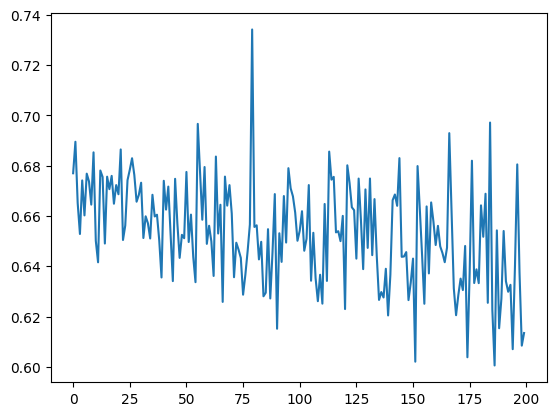

Train Accuracies


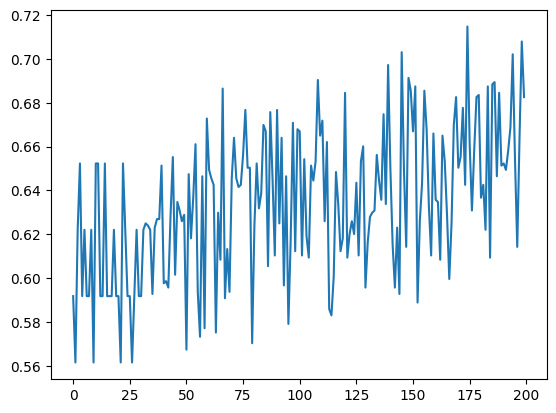

Validation Losses


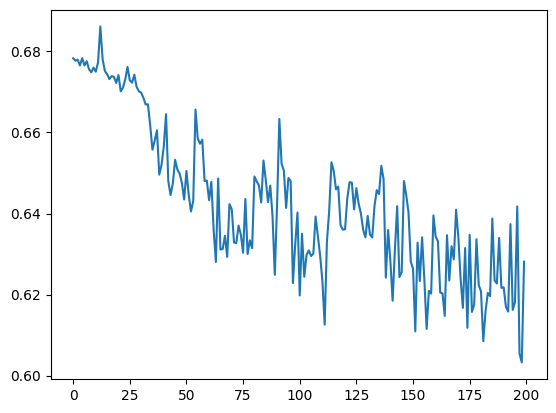

Validation Accuracies


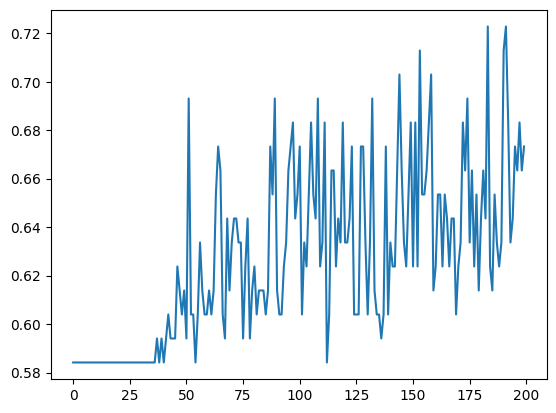

In [12]:
print("Train Losses")
plt.plot(train_losses)
plt.show()
print("Train Accuracies")
plt.plot(train_accuracies)
plt.show()
print("Validation Losses")
plt.plot(val_losses)
plt.show()
print("Validation Accuracies")
plt.plot(val_accuracies)
plt.show()

## Performance on the test set

In [13]:
seed_everything(77)
model.eval()
test_loss = 0.0
test_acc=0.0
for i, data in enumerate(tqdm(test_loader)):
        data = data.to(device)
        pred = model(data.x, data.edge_index, data.batch)
        loss = criterion(pred.squeeze(), data.y.type(torch.float))
        probs=sigmoid(pred.squeeze())
        acc=accuracy_score(data.y.cpu(),torch.round(probs).detach().cpu())
        test_acc+=acc
        test_loss += loss.item()

epoch_test_loss=test_loss/len(test_loader) # Average test loss
epoch_test_accuracy=test_acc/len(test_loader) #Average test accuracy
print(f"Test loss epoch {epoch}: ", epoch_test_loss)
print(f"Test accuracy epoch {epoch}: ", epoch_test_accuracy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.42it/s]

Test loss epoch 199:  0.6481542587280273
Test accuracy epoch 199:  0.6696428571428571


## Further Results

In this notebook is presented the original implementation of the paper, however we offered the chance to modify some parameters. We exploited this possibility ourselves to do several experiments.  
Additionally, we performed some more tests by substituting existing features (e.g. changing the convolution library), or inserting new ones (e.g. self-made residual connections).  
To have a complete map of our tests, please look at _experiments.pdf_ in this repository.